<a href="https://colab.research.google.com/github/DiGyt/neuropynamics/blob/DiGyt_dev/notebooks/multineuron_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install brian2
!git clone https://github.com/DiGyt/neuropynamics/ --branch DiGyt_dev

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 5.8MB 19.0MB/s 
  Created wheel for brian2: filename=Brian2-2.3.0.2-cp36-cp36m-linux_x86_64.whl size=1283451 sha256=6533ffb11a3b358839b9673fe81fa76df82135815a9286a4af58c1ae8fc16f98
  Stored in directory: /root/.cache/pip/wheels/86/b5/f6/0c8f9eec58c01e4af55a4c79a5e0385aea01ed03e4ec36c4ac
Successfully built brian2
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1
Cloning into 'neuropynamics'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 209 (delta 75), reused 66 (delta 7), pack-reused 0
Receiving objects: 100% (209/209), 1.76 MiB | 2.11 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [2]:
from neuropynamics.src.plotting import (plot_signals, plot_cmesh, plot_spikes, plot_synapses)
from brian2 import mV, ms, volt, second
from brian2 import (start_scope, NeuronGroup, Synapses, PoissonGroup,
                    StateMonitor, SpikeMonitor, run)
import networkx as nx
import numpy as np

/usr/local/lib/python3.6/dist-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "


First of all, we will define a Poisson neuron group that produce random spikes from a poisson process. To visualize the spiking process, we will plot them.

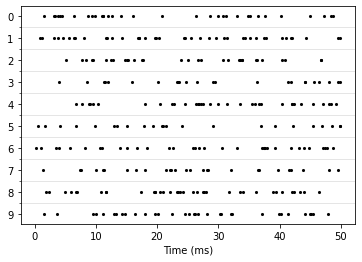

In [3]:
# start brian2 scope
start_scope()

# we want 10 neurons to fire 700 times per second on average
poisson_inp = PoissonGroup(10, rates=700/second)

# run a simulation for 50 ms while monitoring the spikes
poisson_spikes = SpikeMonitor(poisson_inp, record=True)
run(50*ms)

# plot them
plot_spikes(poisson_spikes.i, poisson_spikes.t/ms, time_unit="ms")

Now we can build up a larger neuron network including Poisson generated inputs and differently tuned Izhikevich neurons.

In [58]:
# start brian2 scope
start_scope()

# define the number of neurons for both groups
N_regular = 10
N_chattering = 10

# define the average poisson input spiking rate
input_rate = 300/second

# start creating Izhikevich neurons based on our known Izhikevich model
model = '''dvm/dt = (0.04/ms/mV)*vm**2+(5/ms)*vm+140*mV/ms-w + I : volt
dw/dt = a*(b*vm-w) : volt/second
c : volt
d : volt/second'''
threshold = 'vm > 35*mV'
reset = 'vm = c; w += d'
a = 0.02/ms; b = 0.2/ms; I = 0*volt/second

# create regularly spiking izhikevich neurons
iz_regular = NeuronGroup(N_regular, model=model, threshold=threshold,
                         reset=reset, method='euler', name='Regular')
iz_regular.c = -65*mV
iz_regular.d = 8*volt/second

# create chattering izhikevich neurons
iz_chattering = NeuronGroup(N_chattering, model=model, threshold=threshold,
                            reset=reset, method='euler', name='Chattering')
iz_chattering.c = -50*mV
iz_chattering.d = 2*volt/second

# generate poisson input spikes of the same number as regular neurons
N_poisson = N_regular
poisson_inp = PoissonGroup(N_poisson, rates=input_rate, name='Input')


# now, introduce synapses between the neurons
# start with synapses from the input to the regular neurons
syn_0 = Synapses(poisson_inp, iz_regular, 'weight : volt', on_pre='vm_post += weight')
syn_0.connect(i=np.arange(0, N_poisson),
              j=np.arange(0, N_regular))
syn_0.delay =  1 * ms
syn_0.weight = 30 * mV

# inputs to chattering
syn_1 = Synapses(poisson_inp, iz_chattering, 'weight : volt', on_pre='vm_post += weight')
syn_1.connect(i=np.random.randint(0, N_poisson, N_chattering),
              j=np.arange(0, N_chattering))
syn_1.delay =  1 * ms
syn_1.weight = 30 * mV

# random synapses from regular to chattering
N_synapses = N_chattering
syn_2 = Synapses(iz_regular, iz_chattering, 'weight : volt', on_pre='vm_post += weight')
syn_2.connect(i = np.random.randint(0, N_regular, N_synapses),
              j = np.random.randint(0, N_chattering, N_synapses))
syn_2.delay =  np.random.randint(1, 12, N_synapses) * ms
syn_2.weight = 30 * mV

# random synapses from chattering to regular
N_synapses = N_regular // 2
syn_3 = Synapses(iz_chattering, iz_regular, 'weight : volt', on_pre='vm_post += weight')
syn_3.connect(i = np.random.randint(0, N_chattering, N_synapses),
              j = np.random.randint(0, N_regular, N_synapses))
syn_3.delay =  np.random.randint(1, 12, N_synapses) * ms
syn_3.weight = 30 * mV

# define which neurons to record
regular_states = StateMonitor(iz_regular, 'vm', record=True)
chattering_states = StateMonitor(iz_chattering, 'vm', record=True)
poisson_spikes = SpikeMonitor(poisson_inp, record=True)

# run the simulation
run(100*ms)

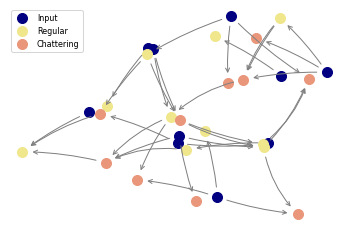

In [65]:
plot_synapses([poisson_inp, iz_regular, iz_chattering],
              [syn_0, syn_1, syn_2, syn_3],
              pos_func=nx.kamada_kawai_layout,
              color_cycle=["navy", "khaki", "darksalmon"],
              legend="best", node_size=100)

# you can check out different graph layouts here:
# https://networkx.github.io/documentation/stable/reference/drawing.html#module-networkx.drawing.layout

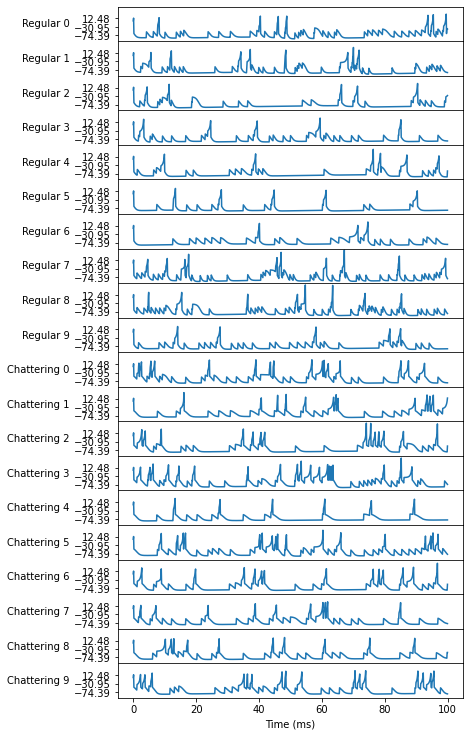

In [60]:
states = np.vstack([regular_states.vm/mV,
                    chattering_states.vm/mV])
names = np.hstack([["Regular " + str(i) for i in range(N_regular)],
                   ["Chattering " + str(i) for i in range(N_chattering)]])
plot_signals(states, regular_states.t/ms, names, spacing=0.12, time_unit="ms")

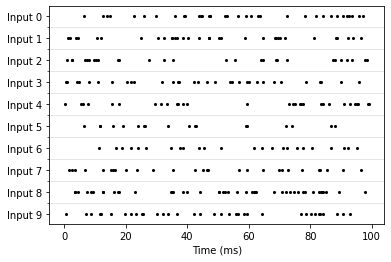

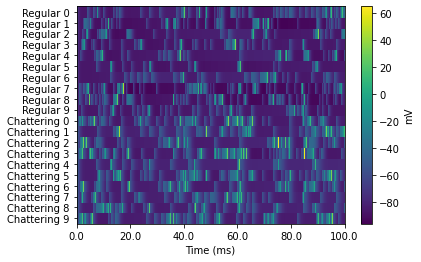

In [62]:
inp_names = ["Input " + str(i) for i in range(N_regular)]
plot_spikes(poisson_spikes.i, poisson_spikes.t/ms, inp_names, time_unit="ms")
plot_cmesh(states, regular_states.t/ms, names, unit="mV", time_unit="ms")